## CASE 2: CNN
Nama: Aurellia Vieryn <br>
NIM : 2440066626 <br>
Dataset 1: https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset <br>
Link Video:
#### Import Our Dataset from Kaggle

In [1]:
!pip install -q Kaggle

Here, we upload our own Kaggle.json from individual's Kaggle account.

In [2]:
from google.colab import files
 
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d misrakahmed/vegetable-image-dataset

100% 534M/534M [00:16<00:00, 37.3MB/s]
100% 534M/534M [00:16<00:00, 33.0MB/s]


In [7]:
!unzip vegetable-image-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Vegetable Images/train/Radish/0001.jpg  
  inflating: Vegetable Images/train/Radish/0002.jpg  
  inflating: Vegetable Images/train/Radish/0003.jpg  
  inflating: Vegetable Images/train/Radish/0004.jpg  
  inflating: Vegetable Images/train/Radish/0005.jpg  
  inflating: Vegetable Images/train/Radish/0006.jpg  
  inflating: Vegetable Images/train/Radish/0007.jpg  
  inflating: Vegetable Images/train/Radish/0008.jpg  
  inflating: Vegetable Images/train/Radish/0009.jpg  
  inflating: Vegetable Images/train/Radish/0010.jpg  
  inflating: Vegetable Images/train/Radish/0011.jpg  
  inflating: Vegetable Images/train/Radish/0012.jpg  
  inflating: Vegetable Images/train/Radish/0013.jpg  
  inflating: Vegetable Images/train/Radish/0014.jpg  
  inflating: Vegetable Images/train/Radish/0015.jpg  
  inflating: Vegetable Images/train/Radish/0016.jpg  
  inflating: Vegetable Images/train/Radish/0017.jpg  
  inflating: Vegetable Images/t

#### Library Imports

In [8]:
import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import glob
from tqdm import tqdm

In [9]:
from torch.utils.data import Dataset

class VegetableDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        
        return image, label


    def get_labels(self, idx):
      image_filepath = self.image_paths[idx]
      label = image_filepath.split('/')[-2]
      label = class_to_idx[label]
      return label

#### Splitting Train

a. Separate the train folder into train and val with the following ratio: 70% train, 30% val (5 points) <br>

Since in our original dataset, there is already the validation data, we will make a new validation in order to complete the instruction given. 

In [10]:
train_path = '/content/Vegetable Images/train'
test_path = '/content/Vegetable Images/test'

In [11]:
train_image_paths = []
classes = []

In [12]:
for data_path in glob.glob(train_path + '/*'):
    classes.append(data_path.split('/')[-1]) 
    train_image_paths.append(glob.glob(data_path + '/*'))
    
train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

print('train_image_path example: ', train_image_paths[0])
print('class example: ', classes[0])

train_image_path example:  /content/Vegetable Images/train/Papaya/0810.jpg
class example:  Radish


In [13]:
train_image_paths, valid_image_paths = train_image_paths[:int(0.7*len(train_image_paths))], train_image_paths[int(0.7*len(train_image_paths)):] 

In [14]:
test_image_paths = []
for data_path in glob.glob(test_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten(test_image_paths))

print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))

Train size: 10500
Valid size: 4500
Test size: 3000


From the information we have got about our datasets, there are 10500 images for train, 4500 images for validation, and 3000 images for testing.

In [15]:
print(len(classes))

15


There is 15 classes for our image dataset, which is correct if the folders in the files is opened. Then, we make index for the classes. Because we have 15, the indexes will be 0 to 14.

In [16]:
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [17]:
print(class_to_idx)

{'Radish': 0, 'Pumpkin': 1, 'Carrot': 2, 'Bitter_Gourd': 3, 'Papaya': 4, 'Tomato': 5, 'Broccoli': 6, 'Brinjal': 7, 'Bottle_Gourd': 8, 'Bean': 9, 'Potato': 10, 'Cucumber': 11, 'Capsicum': 12, 'Cabbage': 13, 'Cauliflower': 14}


#### Transform
Before we make out dataset, we transform our data first.

In [18]:
train_transforms = A.Compose(
    [
        A.Resize (height=32, width=32),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.Resize (height=32, width=32),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

#### Making the Datasets

In [19]:
train_dataset = VegetableDataset(train_image_paths,train_transforms)
valid_dataset = VegetableDataset(valid_image_paths,train_transforms)
test_dataset = VegetableDataset(test_image_paths,test_transforms)

#### Visualize the Datasets

We want to see what kind of images there are, so we will visualize the images randomly.

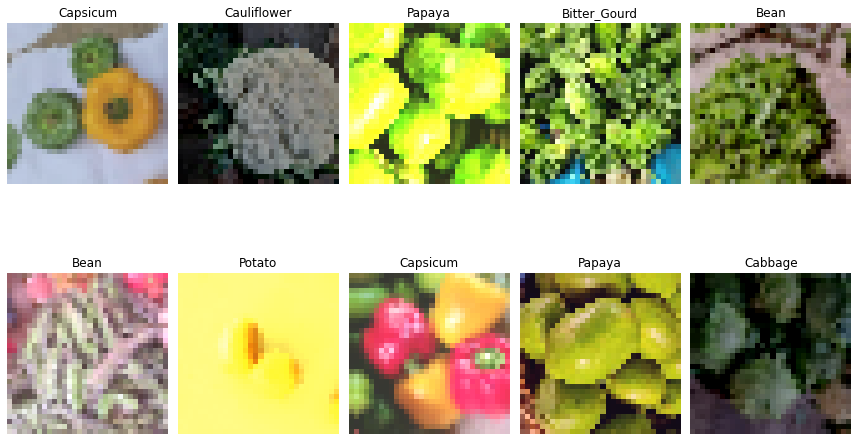

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_augmentations(dataset, idx=0, samples=10, cols=5, random_img = False):
    
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    
        
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(train_image_paths))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[lab])
    plt.tight_layout(pad=1)
    plt.show()    

visualize_augmentations(train_dataset,np.random.randint(1,len(train_image_paths)), random_img = True)

#### Create Loader

This is used to help easier processing.

In [21]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=64, shuffle=True
)


test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False
)

In [22]:
dataloaders = {'train': train_loader,
              'valid': valid_loader,
              'Test': test_loader}
dataset_sizes = {
    'train': len(train_dataset),
    'valid': len(valid_dataset),
    'Test': len(test_dataset)
}

#### Making the CNN Model 

b. Create a CNN model to extract features and train a classifier from the extracted features. The
size of the input is 32x32x3 and the suggested architecture of your CNN is as follows: Conv
(16.3x3), Relu, Conv (32.3x3), Relu, Conv (64.3x3), 2FC, and Softmax (number_class ).
(10 points)

In [23]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms

In [24]:
class Net(nn.Module):
    def __init__(self, num_classes=15):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1),
            nn.ReLU())
        self.layer3 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.fc = nn.Linear(43264, 4096)
        self.fc1 = nn.Linear(4096, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1) #gambar to vector
        out = self.fc(out)
        out = self.fc1(out)
        out = F.softmax(out,dim=0)
        return out

In [25]:
net = Net()
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

In [26]:
epochs = 5
 
train_mean_losses = []
valid_mean_losses = []

valid_best_loss = np.inf

for i in range(epochs):  
    #===============================================================
    # training 
    train_losses = []
    
    print("=========================================================")
    print("Epoch {}".format(i))
    
    for iteration, batch_data in enumerate(train_loader):
        X_batch, y_batch = batch_data
        
        optimizer.zero_grad()
        
        out = net(X_batch)
        loss = criterion(out, y_batch.squeeze())
        
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss)
    
    train_mean_loss = torch.mean(torch.stack(train_losses))
    print('training loss: {:10.8f}'.format(train_mean_loss))
    
    train_mean_losses.append(train_mean_loss)
    
    #===============================================================
    # validation
    valid_losses = []
    with torch.set_grad_enabled(False):
        for iteration, batch_data in enumerate(valid_loader):
            X_batch, y_batch = batch_data

            out = net(X_batch)
            loss = criterion(out, y_batch.squeeze())
            valid_losses.append(loss)
            
        valid_mean_loss = torch.mean(torch.stack(valid_losses))
        print('validation loss: {:10.8f}'.format(valid_mean_loss))
        
        valid_mean_losses.append(valid_mean_loss)
        
        if valid_mean_loss.cpu().numpy()[()] < valid_best_loss:
            valid_best_loss = valid_mean_loss
            torch.save(net.state_dict(), "best_model.pth")
            best_epoch = i
    #===============================================================
            

Epoch 0
training loss: 2.70805287
validation loss: 2.70804143
Epoch 1
training loss: 2.70800734
validation loss: 2.70800853
Epoch 2
training loss: 2.70801067
validation loss: 2.70798683
Epoch 3
training loss: 2.70797014
validation loss: 2.70796347
Epoch 4
training loss: 2.70795774
validation loss: 2.70793700


In [27]:
net.load_state_dict(torch.load("best_model.pth"))

<All keys matched successfully>

We have finished training our model, now we want to count the accuracy, precision and recall before we try to make the model better.

In [28]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 9 %


In [29]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Radish is 8.0 %
Accuracy for class: Pumpkin is 8.5 %
Accuracy for class: Carrot is 9.5 %
Accuracy for class: Bitter_Gourd is 11.5 %
Accuracy for class: Papaya is 8.5 %
Accuracy for class: Tomato is 7.0 %
Accuracy for class: Broccoli is 3.5 %
Accuracy for class: Brinjal is 5.5 %
Accuracy for class: Bottle_Gourd is 2.5 %
Accuracy for class: Bean  is 4.0 %
Accuracy for class: Potato is 23.5 %
Accuracy for class: Cucumber is 9.0 %
Accuracy for class: Capsicum is 21.0 %
Accuracy for class: Cabbage is 10.5 %
Accuracy for class: Cauliflower is 5.5 %


In [30]:
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [31]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        output = net(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

In [32]:
baseline_accuracy = accuracy_score(y_true, y_pred)
print("Accuracy: {}".format(baseline_accuracy))

Accuracy: 0.092


In [33]:
precision_score(y_true, y_pred, average='macro')

0.08793256478546403

In [34]:
from sklearn.metrics import recall_score

recall_score(y_true, y_pred, average='macro')

0.092

The model has an accuracy of 0.092, precision of 0.087, and recall of 0.092. To be honest, from the results, it can't be say the model is good because it's only around 9% but it's okay we will try to improve this by hypertuning and modifying the architecture.

#### Hypertuning and Modify Architecture

For the hypertuning, we will tune the parameters epoch, momentum, learning rate and the output of the first fully connected layer (chosen because not sure what number to choose). Not that much but maybe it will improve the results. Also for the archictetures, we will add Dropout, Batch Normalization, and Pooling. <br>

Another thing to mention is we've been seeing very high training loss and validation loss (more than 2), so in order to try to avoid it, we will remove the softmax layer because cross entropy loss and softmax are not a good match.

In [35]:
class Net(nn.Module):
    def __init__(self, num_classes=15, L1=4096):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(16))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(  
            nn.Dropout(0.5),
            nn.Linear(10816, L1), 
            nn.ReLU())
        self.fc1 = nn.Linear(L1, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1) #gambar to vector
        out = self.fc(out)
        out = self.fc1(out)
        return out

We will use the tuning method from ray library since it is the most efficient and fast method to run through the parameters.

In [ ]:
! pip install ray torch torchvision filelock

In [37]:
import torch.optim as optim
from ray import tune
from ray.tune.examples.mnist_pytorch import get_data_loaders, ConvNet, train, test

In [38]:
def train_vege(config): 
    model = Net()
    optimizer = torch.optim.SGD(model.parameters(), lr=config["lr"])
    for i in range(10):
        train(model, optimizer, train_loader)
        acc = test(model, test_loader)
        tune.report(mean_accuracy=acc)

In [51]:
config = {"lr": tune.choice([0.001, 0.005, 0.01, 0.1]),
          'max_epochs': tune.choice([3,5,7,10]),
          'momentum': tune.choice([0.5,0.9,1]),
          'L1': tune.choice([32,64,128,256,512,1024,2048,4096])
         }

In [52]:
analysis = tune.run(train_vege, config=config)

print("Best config: ", analysis.get_best_config(metric="mean_accuracy"))

2022-11-23 14:32:13,037	WARNING callback.py:109 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


Trial name,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,mean_accuracy,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_vege_9ed52_00000,2022-11-23_14-33-06,True,,f01ee0cba4fb471a89357c3a439e9914,"0_L1=32,lr=0.0050,max_epochs=10,momentum=0.9000",1f6a390374ce,10,0.625,172.28.0.2,1173,49.4995,4.67067,49.4995,1669213986,0,,10,9ed52_00000,0.00551081


2022-11-23 14:33:06,333	INFO tune.py:778 -- Total run time: 53.31 seconds (53.17 seconds for the tuning loop).


Best config:  {'lr': 0.005, 'max_epochs': 10, 'momentum': 0.9, 'L1': 32}


The best parameters were shown in the output above, so now we will manually setup those parameters to see better results.

In [53]:
class Net(nn.Module):
    def __init__(self, num_classes=15, L1=32):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(16))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(  
            nn.Dropout(0.5),
            nn.Linear(10816, L1), 
            nn.ReLU())
        self.fc1 = nn.Linear(L1, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1) #gambar to vector
        out = self.fc(out)
        out = self.fc1(out)
        return out

In [54]:
net = Net()
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(net.parameters(), lr=0.005, momentum=0.9)

In [55]:
epochs = 10

train_mean_losses = []
valid_mean_losses = []

valid_best_loss = np.inf

for i in range(epochs):  
    #===============================================================
    # training 
    train_losses = []
    
    print("=========================================================")
    print("Epoch {}".format(i))
    
    for iteration, batch_data in enumerate(train_loader):
        X_batch, y_batch = batch_data
        
        optimizer.zero_grad()
        
        out = net(X_batch)
        loss = criterion(out, y_batch.squeeze())
        
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss)
    
    train_mean_loss = torch.mean(torch.stack(train_losses))
    print('training loss: {:10.8f}'.format(train_mean_loss))
    
    train_mean_losses.append(train_mean_loss)
    
    #===============================================================
    # validation
    valid_losses = []
    with torch.set_grad_enabled(False):
        for iteration, batch_data in enumerate(valid_loader):
            X_batch, y_batch = batch_data

            out = net(X_batch)
            loss = criterion(out, y_batch.squeeze())
            valid_losses.append(loss)
            
        valid_mean_loss = torch.mean(torch.stack(valid_losses))
        print('validation loss: {:10.8f}'.format(valid_mean_loss))
        
        valid_mean_losses.append(valid_mean_loss)
        
        if valid_mean_loss.cpu().numpy()[()] < valid_best_loss:
            valid_best_loss = valid_mean_loss
            torch.save(net.state_dict(), "best_model.pth")
            best_epoch = i
    #===============================================================
            

Epoch 0
training loss: 2.25923753
validation loss: 2.16635180
Epoch 1
training loss: 1.95517838
validation loss: 1.94739175
Epoch 2
training loss: 1.78368878
validation loss: 1.77001715
Epoch 3
training loss: 1.69901848
validation loss: 1.66913438
Epoch 4
training loss: 1.60170579
validation loss: 1.61230767
Epoch 5
training loss: 1.53735483
validation loss: 1.56979072
Epoch 6
training loss: 1.48536551
validation loss: 1.63456059
Epoch 7
training loss: 1.43505299
validation loss: 1.58348632
Epoch 8
training loss: 1.41352677
validation loss: 1.42082953
Epoch 9
training loss: 1.36268413
validation loss: 1.41960287


In [56]:
net.load_state_dict(torch.load("best_model.pth"))

<All keys matched successfully>

Again, we will see the accuracy for this model. It should be better than the previous one.

In [57]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 51 %


In [58]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Radish is 59.5 %
Accuracy for class: Pumpkin is 40.0 %
Accuracy for class: Carrot is 29.0 %
Accuracy for class: Bitter_Gourd is 57.5 %
Accuracy for class: Papaya is 34.5 %
Accuracy for class: Tomato is 55.0 %
Accuracy for class: Broccoli is 73.5 %
Accuracy for class: Brinjal is 58.5 %
Accuracy for class: Bottle_Gourd is 73.5 %
Accuracy for class: Bean  is 36.0 %
Accuracy for class: Potato is 69.5 %
Accuracy for class: Cucumber is 47.5 %
Accuracy for class: Capsicum is 45.0 %
Accuracy for class: Cabbage is 81.0 %
Accuracy for class: Cauliflower is 30.5 %


In [59]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        output = net(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

In [60]:
modif_accuracy = accuracy_score(y_true, y_pred)
print("Accuracy: {}".format(modif_accuracy))

Accuracy: 0.507


In [61]:
precision_score(y_true, y_pred, average='macro')

0.5826290537204445

In [62]:
recall_score(y_true, y_pred, average='macro')

0.5069999999999999

The accuracy of the model increased by a lot meaning the method we tried worked quite well. I think it's mostly because of the architectural model since we don't hypertune the parameters that much, especially the removal of the softmax function.<br>

We added some things like Batch Normalization which makes the training more stable, also Max Pooling which reduce the inputs, and Dropout which drops some of the neurons.

#### Model Evaluation

As from what we have gotten before, the baseline model's accuracy was only 9% and the modified model's accuracy reached an increase around 41%. 

In [63]:
print(f'Accuracy for baseline model: {baseline_accuracy}')
print(f'Accuracy for modified model: {modif_accuracy}')

Accuracy for baseline model: 0.092
Accuracy for modified model: 0.507


This means that the modified model is indeed the better model.